In [2]:
# necessary imports
import numpy as np
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.primitives import Sampler, Estimator

from squlearn.feature_map import YZ_CX_FeatureMap
from squlearn.kernel.matrix import FidelityKernel, ProjectedQuantumKernel
from squlearn.kernel.ml import QGPR
from squlearn.kernel.optimization import KernelOptimizer
from squlearn.kernel.optimization import NLL
from generate_training_data_xsinx import generate_points

In [3]:
# load quantum instance options
statevec = Aer.get_backend('statevector_simulator')
backend = Aer.get_backend('qasm_simulator')
QI_qasm = QuantumInstance(backend,shots=5000)
sampler = Sampler()
estimator = Estimator()

In [4]:
import matplotlib.pyplot as plt
# Generate training data.
training_start= np.pi * 0
training_end = np.pi * 2
noise_variance = 0.2
training_data = generate_points(
    training_start, training_end, section=7, quota=[2, 5], noise=noise_variance)
X, Y = training_data
# Setup testing locations.
# You can change the testing locations here.
X_test = np.linspace(training_start, training_end + 0*np.pi, 50)
func = X_test * np.sin(X_test)

In [5]:
# set up quantum kernel and qgpr
num_qubits = 4
fmap = YZ_CX_FeatureMap(
    num_qubits,num_features=num_qubits,num_layers=2,c=1.0)
np.random.seed(0)
param = np.random.rand(fmap.num_parameters)
q_kernel = FidelityKernel(
    feature_map=fmap,quantum_instance=statevec)

In [6]:
pqk_kernel_estimator = ProjectedQuantumKernel(
      pqk_hyper_param=2.0,
      feature_map=fmap,
      primitive=estimator
)
#pqk_kernel_estimator.assign_parameters(param)
#qgpr_ansatz_pqk_estimator = QGPR(
#    quantum_kernel=pqk_kernel_estimator, sigma=noise_variance**2)

In [7]:
from quantum_kernel.kernel_optimization import frederics_adam as adam 
adam = adam.ADAM(maxiter=50, lr=0.1)
nll_loss = NLL(quantum_kernel=q_kernel, sigma=noise_variance**2)
optimizer = KernelOptimizer(loss=nll_loss,
    optimizer=adam, initial_parameters=param)

In [16]:
#adam = adam.ADAM(maxiter=50, lr=0.1)
nll_loss_pqk = NLL(quantum_kernel=pqk_kernel_estimator, sigma=noise_variance**2)
optimizer_pqk = KernelOptimizer(loss=nll_loss_pqk,
    optimizer=adam, initial_parameters=param)

In [11]:
opt_result = optimizer.run_optimization(x=X.reshape(-1,1), y=Y)

KeyboardInterrupt: 

In [17]:
opt_result_pqk = optimizer_pqk.run_optimization(x=X.reshape(-1,1), y=Y)

running job on ibmq backend with job id:  21652b72-1629-41a8-93a4-f7d785e5a070
running job on ibmq backend with job id:  bf44d4f8-0c7c-4974-be6d-772819c15469
running job on ibmq backend with job id:  27859da4-6684-4e99-a17f-50527f4385c6
running job on ibmq backend with job id:  f169fbbd-146d-4e3c-a8a4-2ccb7c07e0e2
running job on ibmq backend with job id:  9c6c022c-880d-438d-b533-a23636005429
running job on ibmq backend with job id:  5bd0f4a7-5b49-434f-ae45-181929badeed
running job on ibmq backend with job id:  63500122-b167-4db4-aebd-1955dce6da09
running job on ibmq backend with job id:  1b884f4d-5e20-45df-9036-438e9811ed3d
running job on ibmq backend with job id:  14e33903-845d-40bc-8a09-dfa471d540fe
running job on ibmq backend with job id:  2f315a14-5779-4698-b78a-243e87a9081e
running job on ibmq backend with job id:  cac10d90-c72d-462a-adc7-681bfb5f9e27
running job on ibmq backend with job id:  16e61713-e473-4a9d-8ec1-034b2e0630cd
running job on ibmq backend with job id:  90359218-e

KeyboardInterrupt: 

In [11]:
#perform qgpr
optimal_parameters = opt_result.x
q_kernel.assign_parameters(optimal_parameters)
qgpr_ansatz = QGPR(quantum_kernel=q_kernel, sigma=noise_variance**2)
qgpr_ansatz.fit(X_train=X.reshape(-1,1), y_train=Y)
qgpr_mean, qgpr_std = qgpr_ansatz.predict(
    X_test=X_test.reshape(-1,1)
)

In [14]:
#perform qgpr
optimal_parameters = opt_result_pqk.x
pqk_kernel_estimator.assign_parameters(optimal_parameters)
qgpr_ansatz = QGPR(quantum_kernel=pqk_kernel_estimator, sigma=noise_variance**2)
qgpr_ansatz.fit(X_train=X.reshape(-1,1), y_train=Y)
qgpr_mean, qgpr_std = qgpr_ansatz.predict(
    X_test=X_test.reshape(-1,1)
)

running job on ibmq backend with job id:  41d06e05-663b-46a3-beaf-0fe3c71f24df
running job on ibmq backend with job id:  070b73b7-5497-4540-9228-8e0cdc74b62e
running job on ibmq backend with job id:  4443c788-ee25-45e4-9447-ee2fd9b21850
running job on ibmq backend with job id:  6ba47616-a79e-4b08-bcc7-eb29550f5b3a


Text(0, 0.5, '$f(x)$')

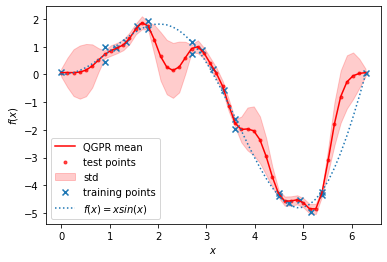

In [15]:
# plot result
plt.plot(X_test.reshape(-1,1), qgpr_mean, color='red', label='QGPR mean')
plt.scatter(X_test.reshape(-1,1), qgpr_mean, marker='.',
label='test points', color='red', alpha=0.7)
plt.fill_between(X_test.reshape(-1),
                 qgpr_mean.reshape(-1) -  qgpr_std,
                 qgpr_mean.reshape(-1) + qgpr_std,
                 color='red',label='std', alpha=0.2)
marker_size = 50
plt.scatter(X, Y, marker='x', label='training points')
plt.plot(X_test, func, label=r"$f(x) = x sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

Text(0.5, 1.0, 'Negative Log-Likelihood with adam optimizer')

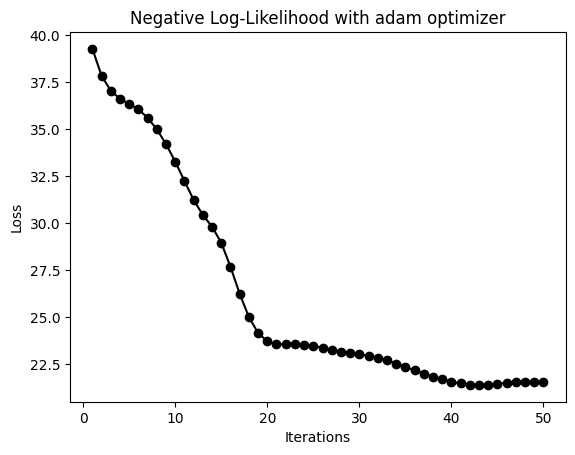

In [13]:
# plot loss
loss = optimizer._optimizer._loss
plt.plot([i+1 for i in range(optimizer._optimizer._t)], np.array(loss), c="k", marker="o")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Negative Log-Likelihood with adam optimizer')
#plt.yscale('log')